# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features

Populating the interactive namespace from numpy and matplotlib


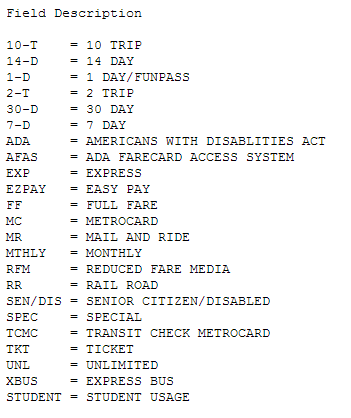

In [2]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [3]:
mta = np.load('MTA_Fare.npy')

In [4]:
type(mta)

numpy.ndarray

In [5]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [7]:
# convert to float
mta = mta[:].astype(float)

In [8]:
# replace -1 with NaN
mta[mta == -1] = np.nan

In [26]:
# create date range
date_rg = pd.date_range(start = '05/19/2010', periods = 194, freq = 'W-SUN')
#wks_since = (date_rg - date_rg[0]) / np.timedelta64(1,'W')

In [27]:
date_rg

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

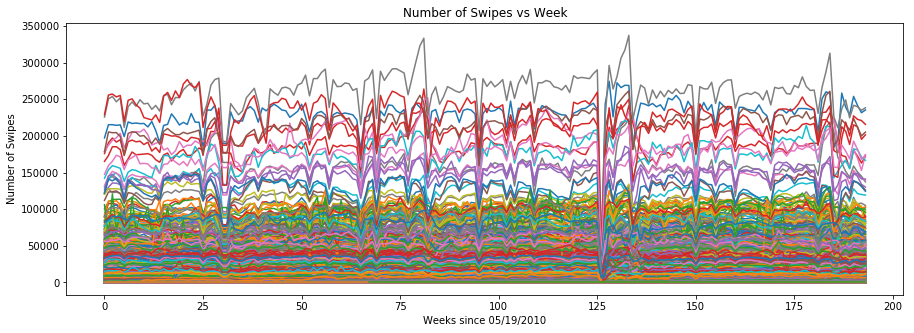

In [14]:
# plot in natural space
pl.figure(figsize=(15,5))
for i in range(600):
        for j in range(23):
                pl.plot(mta[i][j])
pl.xlabel('Weeks since 05/23/2010')
pl.ylabel('Number of Swipes')
pl.title('Number of Swipes vs Week')
pl.show()

**Figure 1:** The plot above shows number of swipes as a function of weeks since 5/23/10. Each line is a time series representing a station and rider type. We can see a significant dip near week 125, but it is difficult to see fully from this plot. It may be clearer in a plot using log space for the number of swipes.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


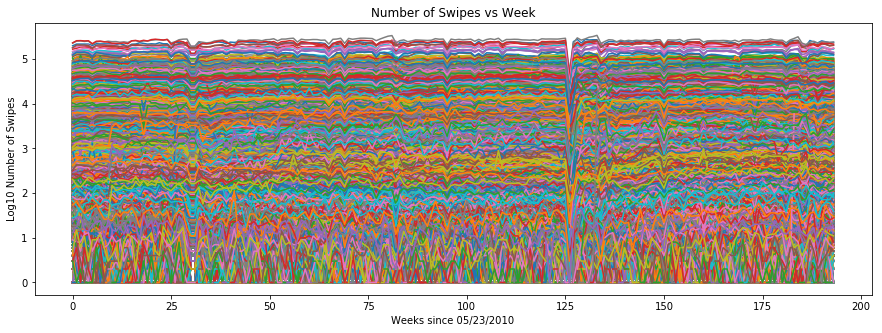

In [28]:
# plot in log space
pl.figure(figsize=(15,5))
for i in range(600):
        for j in range(23):
                pl.plot(np.log10(mta[i][j]))
pl.xlabel('Weeks since 05/23/2010')
pl.ylabel('Log10 Number of Swipes')
pl.title('Number of Swipes vs Week')
pl.show()

**Figure 2:** In the plot above, log10 of the number of swipes is plotted against weeks since 5/23/10. Each line again represents a times series for each station and rider type, but this time the dependent variable is transformed by taking the log10 of swipes. We can now more clearly see the dip spotted in Figure 1 at just after week 125.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [15]:
##single point change detector
# as in https://www.slideshare.net/FrankKelly3/changepoint-detection-with-bayesian-inference
# with modifications for efficiency

def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': np.nanmean(data[:changePoint+1]), 
            'meanAfter': np.nanmean(data[(changePoint+1):])}

In [17]:
# view the point of change for the first station and first rider type
change = changeFinder(mta[0][0])
print('pointofchange: %i, meanBefore: %f, meanAfter: %f' %(change['pointOfChange'],
                                                           change['meanBefore'], 
                                                           change['meanAfter']))

pointofchange: 127, meanBefore: 67437.259843, meanAfter: 41294.615385


In [18]:
# condense rider type and station
mta_weeklytype = np.nansum(mta, axis=0)
mta_weekly = np.nansum(mta_weeklytype, axis=0)

In [19]:
# swipes for weeks 125 to 127
mta_weekly[125:128]

array([ 32128466.,   5218686.,  25647825.])

In [29]:
# difference occurs at weeks 126 to 127
date_rg[127]

Timestamp('2012-10-28 00:00:00', freq='W-SUN')

In [24]:
# check 3 sigma line
sigma = nanstd(mta_weekly)
threesigma = sigma*3
print('Threshhold for 3 sigma: %f'%threesigma)

Threshhold for 3 sigma: 8951881.265103


In [30]:
print('deviation for week 126 to 127 is', mta_weekly[127] - mta_weekly[126])

deviation for week 126 to 127 is 20429139.0


The week of the change directly corresponds with the landfall of Hurricane Sandy on NYC (October 29, 2012). This hurricane caused catastrophic flooding throughout New York City and significant devastation to downtown Manhattan, through which most subways run. It led to outages on major subway lines and ultimately a significant decrease in ridership during this period.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


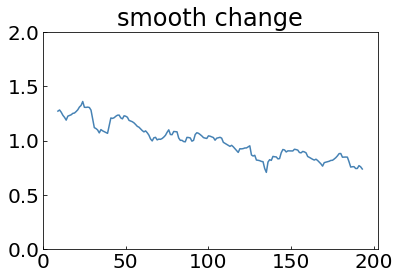

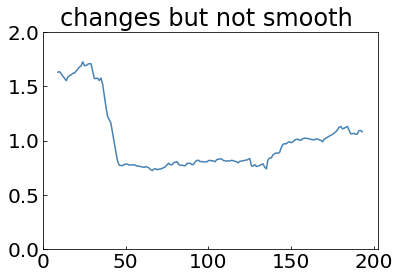

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


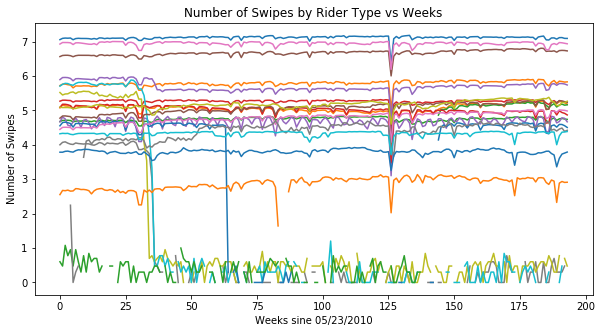

In [35]:
# Plot swipes for each rider type over weeks
mta_weeklytypelog=log10(mta_weeklytype)
fig=figure(figsize=(10,5))
ax=pl.subplot(111)

for i in list(range(0,22)):
    ax.plot(mta_weeklytypelog[i])

ax.set_xlabel('Weeks sine 05/23/2010')
ax.set_ylabel('Number of Swipes')
ax.set_title('Number of Swipes by Rider Type vs Weeks')
pl.show()

**Figure 3:** The figure above shows swipes by week per rider type in the different color lines. You can see that all types (lines) show a significant drop at the end of 2012.

In [36]:
# transform to rolling mean
mta_pivot = mta_weeklytype.T
weeklytype = pd.DataFrame(data=mta_pivot)
weeklytype_rolling = weeklytype.rolling(6, min_periods=1, center=True).mean()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


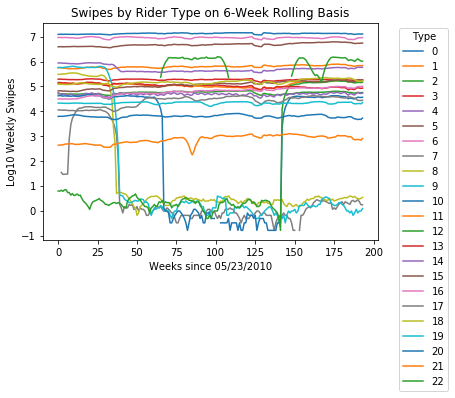

In [37]:
# plot rolling mean
log10(weeklytype_rolling).plot()
pl.xlabel('Weeks since 05/23/2010')
pl.ylabel('Log10 Weekly Swipes')
pl.title('Swipes by Rider Type on 6-Week Rolling Basis')
pl.legend(loc=2,title='Type', bbox_to_anchor=(1.05, 1))
pl.show()

**Figure 4:** The plot above shows the log10 of weekly swipes on a rolling 6 week basis per card type. You can see considerable shifts in activity around the event time but the high volume of lines makes it difficult to interpret.

In [38]:
# print ratio of start and end mean for each rider type
for i in list(range(0,22)): 
    startav = weeklytype_rolling[i][10]
    endav = weeklytype_rolling[i][118]
    ratio = startav/endav
    print('Type %i' %i)
    print('Start Mean: %f'%startav)
    print('End Mean: %f' %endav)
    print('Ratio: %f' %ratio)

Type 0
Start Mean: 12340141.500000
End Mean: 14113820.166667
Ratio: 0.874330
Type 1
Start Mean: 513755.833333
End Mean: 631366.166667
Ratio: 0.813721
Type 2
Start Mean: 49012.833333
End Mean: 65461.000000
Ratio: 0.748733
Type 3
Start Mean: 187330.333333
End Mean: 193437.333333
Ratio: 0.968429
Type 4
Start Mean: 43312.833333
End Mean: 45230.333333
Ratio: 0.957606
Type 5
Start Mean: 4021296.500000
End Mean: 5134884.666667
Ratio: 0.783133
Type 6
Start Mean: 8808369.833333
End Mean: 8785898.000000
Ratio: 1.002558
Type 7
Start Mean: 10645.833333
End Mean: 0.666667
Ratio: 15968.750000
Type 8
Start Mean: 348996.666667
End Mean: 2.500000
Ratio: 139598.666667
Type 9
Start Mean: 638081.000000
End Mean: 1.333333
Ratio: 478560.750000
Type 10
Start Mean: 41101.166667
End Mean: 0.333333
Ratio: 123303.500000
Type 11
Start Mean: 129979.166667
End Mean: 86469.833333
Ratio: 1.503174
Type 12
Start Mean: 4.166667
End Mean: 2.000000
Ratio: 2.083333
Type 13
Start Mean: 132356.666667
End Mean: 97772.166667
R

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


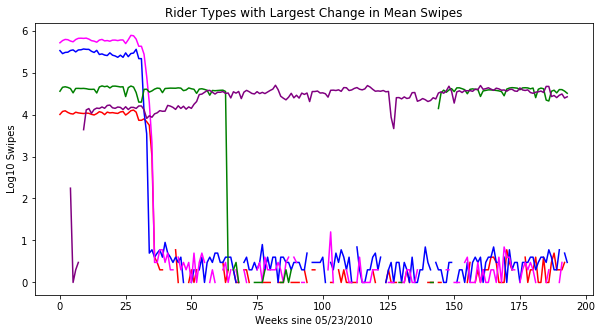

In [40]:
# plot those with largest change in means
fig = figure(figsize=(10,5))
ax2 = pl.subplot(111)
bigchange = [7,8,9,10,17]
colors = ['red', 'blue', 'magenta', 'green', 'purple']
k = 0
for i in bigchange: 
    ax2.plot(mta_weeklytypelog[i], color=colors[k])
    k += 1

ax2.set_xlabel('Weeks sine 05/23/2010')
ax2.set_ylabel('Log10 Swipes')
ax2.set_title('Rider Types with Largest Change in Mean Swipes')
ax2.legend(line=bigchange, label=colors)
pl.show()

**Figure 5:** The plot above shows the log10 rolling number of swipes per week for the 5 types with the highest identified change-- [7,8,9,10,17], shown in ['red', 'blue', 'magenta', 'green', 'purple'] respectively. You can see that these lines all start and end with considerably different values and change significantly over the life of the cycle. In particular, line 17 shows as pretty steady with the most significant dip at the time of Sandy.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [71]:
mta.reshape(600*23, 194)

(194,)

In [60]:
label = np.tile(range(23), 406)[:9317]
label.shape

(9317,)

In [61]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [41]:
stationweeklymean = np.nanmean(mta, axis=1)
stationsmeans = np.nanmean(stationweeklymean, axis=1)
stationsmeans.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(600,)

In [62]:
stationsstd = np.nanstd(stationweeklymean, axis=1)
stationsstd.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [50]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([  2,   2,   2, ..., 550, 550, 550])

In [63]:
stationid.shape

(13800,)

In [11]:
tots = mta.reshape....
tots.shape

(9317, 194)

In [13]:
normed_time_series_mean = ...
normed_time_series_std = ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [15]:
normed_time_series_std[:10]

[1.395418982736398,
 0.040502828714548786,
 0.005274169311689245,
 0.015024618528380378,
 0.010724532270930892,
 0.46734881809359824,
 0.7818394435461803,
 0.0013976175988299514,
 0.17261222074600674,
 0.07396098098064302]

In [18]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(9317,)

In [19]:
tsmean[:10]

array([5.79828866e+04, 1.80932474e+03, 2.34865979e+02, 7.30041237e+02,
       2.90108247e+02, 1.98267680e+04, 3.02422629e+04, 8.47422680e+00,
       9.67087629e+02, 4.26824742e+02])

In [93]:
tsstdev[:10]


array([18634.01356896,   540.86282986,    70.42970157,   200.63432488,
         143.21224115,  6240.83828981, 10440.45335489,    18.66337324,
        2305.01269034,   987.653128  ])

Text(0, 0.5, 'standardized number of rides')

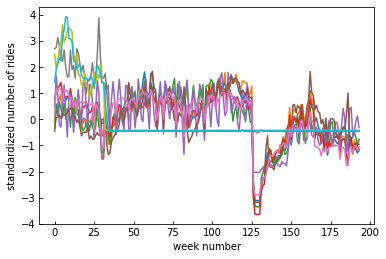

In [25]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [34]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

[71890.84869151471,
 2091.2375892149093,
 282.7639968279143,
 915.9172085646317,
 407.4856463124503,
 21297.24948453608,
 41997.96748612212,
 29.473909595559086,
 3439.0558287073763,
 1505.7963521015074]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

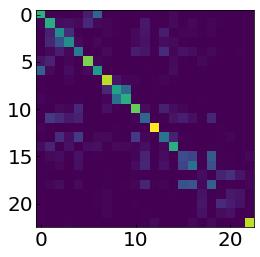

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

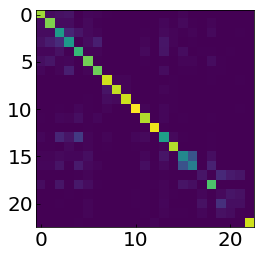

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   